In [1]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [2]:
import findspark
findspark.init('/home/ola/spark-3.0.3')

In [3]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
import urllib
import pandas as pd
import wget

In [4]:
spark = SparkSession.builder.appName ("oladata").getOrCreate()

22/04/05 08:26:52 WARN Utils: Your hostname, ola-virtual-machine resolves to a loopback address: 127.0.1.1; using 192.168.181.130 instead (on interface ens33)
22/04/05 08:26:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/04/05 08:26:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [5]:
import tarfile

In [6]:
df= urllib.request.urlretrieve("https://cdn.captifytechnologies.com/samples/sampled_kws.tar.gz", "sampled_kws.tar.gz")

In [7]:
tf = tarfile.open("sampled_kws.tar.gz")

In [8]:
tf.extractall('./zip_file')

In [9]:
df1 =spark.read.format("parquet").load("./zip_file/sampled_kws/day=20220222")

In [10]:
df2 = spark.read.format("parquet").load("./zip_file/sampled_kws/day=20220223")

In [11]:
df3 = spark.read.format("parquet").load("./zip_file/sampled_kws/day=20220224")

In [12]:
from functools import reduce
from pyspark.sql import DataFrame

In [13]:
df_total =[df1,df2,df3]

In [14]:
#merging all data df1, df2 and df3 together because they
union_df = reduce(DataFrame.unionAll,df_total)

In [15]:
union_df.show()

+-------------------+--------------------+---------------+-----------+----------+--------------------+--------------------+----------+
|          eventDate|           keyphrase|      urlDomain|publisherId|regionCode|           userAgent|    hashed_concat_id|   anon_ip|
+-------------------+--------------------+---------------+-----------+----------+--------------------+--------------------+----------+
|2022-02-22 01:12:28|miley cyrus unzip...|  inquisitr.com|      12441|          |Mozilla/5.0 (Linu...|d1f758694c32be658...|2147483647|
|2022-02-22 01:21:54| hawaiian last names|               |      12437|     US-FL|Mozilla/5.0 (Linu...|23f340c7e217dc122...|1234471680|
|2022-02-22 01:02:29|lifestyle these p...|moneyawaits.com|      12441|          |Mozilla/5.0 (Linu...|4f8f018a71b986fff...| 643723776|
|2022-02-22 01:48:33|news costco disco...|    eatthis.com|      12441|          |Mozilla/5.0 (Linu...|1f33a4cfee82f158d...|1074392832|
|2022-02-22 01:18:54|general news - di...|             

In [16]:
#checking dataframe schema
union_df.printSchema()

root
 |-- eventDate: string (nullable = true)
 |-- keyphrase: string (nullable = true)
 |-- urlDomain: string (nullable = true)
 |-- publisherId: string (nullable = true)
 |-- regionCode: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- hashed_concat_id: string (nullable = true)
 |-- anon_ip: integer (nullable = true)



In [17]:
from pyspark.sql import functions as F

In [18]:
union_df=union_df.withColumn("eventDate", F.col("eventDate").cast("timestamp"))

In [19]:
union_df.printSchema()

root
 |-- eventDate: timestamp (nullable = true)
 |-- keyphrase: string (nullable = true)
 |-- urlDomain: string (nullable = true)
 |-- publisherId: string (nullable = true)
 |-- regionCode: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- hashed_concat_id: string (nullable = true)
 |-- anon_ip: integer (nullable = true)



In [20]:
publisherid_count = union_df.groupBy('publisherid').count()

In [21]:
publisherid_count_for_graph = publisherid_count.filter(publisherid_count['count'] >1000).sort('count', ascending=False).toPandas()

In [22]:
list(publisherid_count_for_graph[0:20]['publisherid'])

['12437',
 '12441',
 '12160',
 '11488',
 '12846',
 '12413',
 '12161',
 '12222',
 '11515',
 '12306',
 '12564',
 '12414',
 '12433',
 '11946',
 '12780',
 '12761',
 '11860',
 '12162',
 '12561',
 '12426']

In [23]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

/tmp/ipykernel_53893/1315749136.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts['publisherid'] = [x.title() for x in counts['publisherid']]


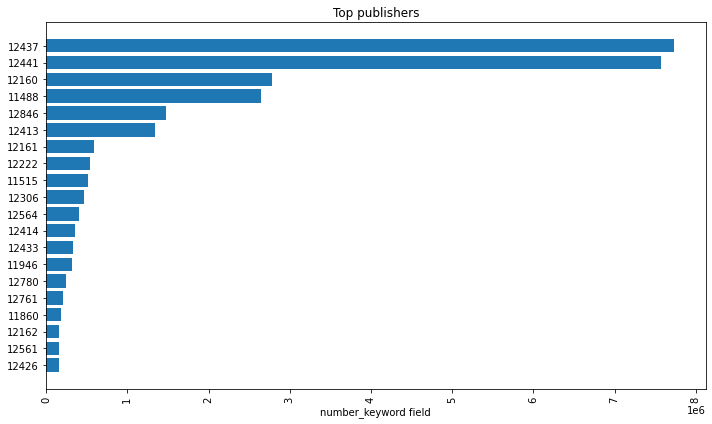

In [24]:
#plotting graph to show top publishers

counts = publisherid_count_for_graph[0:20]
counts['publisherid'] = [x.title() for x in counts['publisherid']]

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(y=counts['publisherid'], 
       width=counts['count'])
ax.set_title("Top publishers")
ax.set_xlabel("number_keyword field")
plt.xticks(rotation=90)
ax.invert_yaxis()

In [25]:
from pyspark.sql.functions import to_date

In [26]:
first_ten_date = union_df.select(to_date(union_df.eventDate, 'dd-MM-yyyy HH:mm:ss').alias('date')) \
    .orderBy('eventDate').take(10)

In [27]:
first_ten_date

[Row(date=datetime.date(2022, 2, 22)),
 Row(date=datetime.date(2022, 2, 22)),
 Row(date=datetime.date(2022, 2, 22)),
 Row(date=datetime.date(2022, 2, 22)),
 Row(date=datetime.date(2022, 2, 22)),
 Row(date=datetime.date(2022, 2, 22)),
 Row(date=datetime.date(2022, 2, 22)),
 Row(date=datetime.date(2022, 2, 22)),
 Row(date=datetime.date(2022, 2, 22)),
 Row(date=datetime.date(2022, 2, 22))]

In [28]:
import sys
from operator import add
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover
import pyspark.sql.functions as f
from pyspark.ml import Pipeline

In [29]:
#spliting into keywords and counting
sf=union_df.withColumn('word', f.explode(f.split(f.col('keyphrase'), ' '))).groupBy('word').count().sort('count', ascending=False)

In [30]:
sf.show()

+-----+-------+
| word|  count|
+-----+-------+
|     |2364192|
| news|2308584|
|   de|1799190|
|    a|1711962|
|  and|1620867|
|    -|1539807|
|  the|1463751|
|   in|1289241|
|   to|1240044|
|   en|1094955|
|   la|1010274|
|   of| 968508|
|    e| 677859|
|  for| 660309|
|video| 506994|
|    i| 498261|
|   on| 492057|
|   tv| 476487|
|   le| 464058|
|   is| 462480|
+-----+-------+
only showing top 20 rows



In [31]:
#removing null values in dataframe
data_df = union_df.select("publisherId", "keyphrase").filter("keyphrase is Not NULL")

In [32]:
#show data_df
data_df.show()

+-----------+--------------------+
|publisherId|           keyphrase|
+-----------+--------------------+
|      12441|miley cyrus unzip...|
|      12437| hawaiian last names|
|      12441|lifestyle these p...|
|      12441|news costco disco...|
|      12437|general news - di...|
|      12437|brie larson see t...|
|      12437|spring data redis...|
|      12437|          main frame|
|      12437|Augmented True Li...|
|      12441|coast guard suspe...|
|      12437|bold beautiful ri...|
|      12437|us figure skating...|
|      12437|hogs haven mock o...|
|      12437|dave chappelle la...|
|      12437|crown royal butte...|
|      12864|movies indiana jo...|
|      12437|     future archives|
|      11847|the legend of her...|
|      12437|7 new movies and ...|
|      12437|afc west - kansas...|
+-----------+--------------------+
only showing top 20 rows



In [33]:
#converts the input string to lowercase and splits it by white spaces
tokenizer = Tokenizer(inputCol="keyphrase", outputCol="words_token")

In [34]:
#apply transform
tokenized = tokenizer.transform(data_df).select('publisherid','words_token')

In [35]:
#show tokenized
tokenized.show()

+-----------+--------------------+
|publisherid|         words_token|
+-----------+--------------------+
|      12441|[miley, cyrus, un...|
|      12437|[hawaiian, last, ...|
|      12441|[lifestyle, these...|
|      12441|[news, costco, di...|
|      12437|[general, news, -...|
|      12437|[brie, larson, se...|
|      12437|[spring, data, re...|
|      12437|       [main, frame]|
|      12437|[augmented, true,...|
|      12441|[coast, guard, su...|
|      12437|[bold, beautiful,...|
|      12437|[us, figure, skat...|
|      12437|[hogs, haven, moc...|
|      12437|[dave, chappelle,...|
|      12437|[crown, royal, bu...|
|      12864|[movies, indiana,...|
|      12437|  [future, archives]|
|      11847|[the, legend, of,...|
|      12437|[7, new, movies, ...|
|      12437|[afc, west, -, ka...|
+-----------+--------------------+
only showing top 20 rows



In [36]:
#filters out stop words from words_token
remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')

In [37]:
#apply transform
data_clean = remover.transform(tokenized).select('publisherid', 'words_clean')

In [38]:
data_clean.show()

+-----------+--------------------+
|publisherid|         words_clean|
+-----------+--------------------+
|      12441|[miley, cyrus, un...|
|      12437|[hawaiian, last, ...|
|      12441|[lifestyle, peopl...|
|      12441|[news, costco, di...|
|      12437|[general, news, -...|
|      12437|[brie, larson, se...|
|      12437|[spring, data, re...|
|      12437|       [main, frame]|
|      12437|[augmented, true,...|
|      12441|[coast, guard, su...|
|      12437|[bold, beautiful,...|
|      12437|[us, figure, skat...|
|      12437|[hogs, haven, moc...|
|      12437|[dave, chappelle,...|
|      12437|[crown, royal, bu...|
|      12864|[movies, indiana,...|
|      12437|  [future, archives]|
|      11847|[legend, heroes, ...|
|      12437|[7, new, movies, ...|
|      12437|[afc, west, -, ka...|
+-----------+--------------------+
only showing top 20 rows



In [40]:
result = data_clean.withColumn('word', f.explode(f.col('words_clean'))) \
  .groupBy('word') \
  .count().sort('count', ascending=False)

In [41]:
new_result =data_clean.select("*").withColumn('word', f.explode(f.col('words_clean'))) \
  .groupBy('word', 'publisherid') \
  .count().sort('count', ascending=False)

In [42]:
result.show()

+------+-------+
|  word|  count|
+------+-------+
|      |2364192|
|  news|2355078|
|    de|1801179|
|     -|1539807|
|    en|1095573|
|    la|1013835|
|     e| 679734|
|    tv| 515205|
| video| 509676|
|    le| 465087|
|    es| 443616|
|    un| 402609|
|    di| 387084|
|    us| 384423|
|    il| 353142|
|futbol| 346983|
|   que| 332037|
|  best| 324978|
|   les| 307719|
|   new| 302583|
+------+-------+
only showing top 20 rows



In [43]:
new_result.show()

+--------+-----------+-------+
|    word|publisherid|  count|
+--------+-----------+-------+
|       -|      12437|1526499|
|    news|      12441| 877440|
|        |      12160| 800946|
|      en|      12441| 452511|
|    news|      12437| 377802|
|        |      11488| 366312|
|      de|      12441| 313293|
|      us|      12441| 289884|
|       e|      12441| 264426|
|  futbol|      12160| 262689|
|      de|      12160| 252279|
|    news|      11488| 250569|
|   video|      12437| 242190|
|    news|      12413| 237048|
|      la|      12441| 230994|
|      es|      12160| 216288|
|      ar|      12441| 199671|
|        |      12441| 194991|
|      tv|      12441| 188436|
|politics|      12437| 184032|
+--------+-----------+-------+
only showing top 20 rows



In [44]:
import pyspark.sql.functions as F

In [45]:
#create column for length of words
new_result= new_result.withColumn("length_of_word", F.length("word"))

In [46]:
#show length of words
new_result.show(truncate=False)

+--------+-----------+-------+--------------+
|word    |publisherid|count  |length_of_word|
+--------+-----------+-------+--------------+
|-       |12437      |1526499|1             |
|news    |12441      |877440 |4             |
|        |12160      |800946 |0             |
|en      |12441      |452511 |2             |
|news    |12437      |377802 |4             |
|        |11488      |366312 |0             |
|de      |12441      |313293 |2             |
|us      |12441      |289884 |2             |
|e       |12441      |264426 |1             |
|futbol  |12160      |262689 |6             |
|de      |12160      |252279 |2             |
|news    |11488      |250569 |4             |
|video   |12437      |242190 |5             |
|news    |12413      |237048 |4             |
|la      |12441      |230994 |2             |
|es      |12160      |216288 |2             |
|ar      |12441      |199671 |2             |
|        |12441      |194991 |0             |
|tv      |12441      |188436 |2   

In [47]:
#find when length of word is not zero
new_result=new_result.filter(new_result.length_of_word!=0)

In [51]:
#show result
new_result.show()

+--------+-----------+-------+--------------+
|    word|publisherid|  count|length_of_word|
+--------+-----------+-------+--------------+
|       -|      12437|1526499|             1|
|    news|      12441| 877440|             4|
|      en|      12441| 452511|             2|
|    news|      12437| 377802|             4|
|      de|      12441| 313293|             2|
|      us|      12441| 289884|             2|
|       e|      12441| 264426|             1|
|  futbol|      12160| 262689|             6|
|      de|      12160| 252279|             2|
|    news|      11488| 250569|             4|
|   video|      12437| 242190|             5|
|    news|      12413| 237048|             4|
|      la|      12441| 230994|             2|
|      es|      12160| 216288|             2|
|      ar|      12441| 199671|             2|
|      tv|      12441| 188436|             2|
|politics|      12437| 184032|             8|
|      de|      11515| 178686|             2|
|   cards|      12437| 174927|    

In [58]:
#dropping length
new_result = new_result.drop("length_of_word")

In [59]:
new_result.show()

+--------+-----------+-------+
|    word|publisherid|  count|
+--------+-----------+-------+
|       -|      12437|1526499|
|    news|      12441| 877440|
|      en|      12441| 452511|
|    news|      12437| 377802|
|      de|      12441| 313293|
|      us|      12441| 289884|
|       e|      12441| 264426|
|  futbol|      12160| 262689|
|      de|      12160| 252279|
|    news|      11488| 250569|
|   video|      12437| 242190|
|    news|      12413| 237048|
|      la|      12441| 230994|
|      es|      12160| 216288|
|      ar|      12441| 199671|
|      tv|      12441| 188436|
|politics|      12437| 184032|
|      de|      11515| 178686|
|   cards|      12437| 174927|
|      de|      12846| 169680|
+--------+-----------+-------+
only showing top 20 rows



In [60]:
pandas_df = new_result.toPandas()

In [ ]:
pandas_df.sort_values(by='count',ascending=False).plot(x ='publisherid', y='count', kind = 'bar')

In [ ]:
pandas_df.sort_values(by='count',ascending=False).plot(x ='word', y='count', kind = 'bar')

In [ ]:
list_df = new_result.select("word", "count").rdd.flatMap(lambda x: x).collect()

In [ ]:
from pyspark.sql.functions import col

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd

In [ ]:
#select distinct publishers
publisherid_df = union_df.select("publisherId").distinct().rdd.flatMap(lambda x: x).collect()